In [56]:
from fp2graph import *
from shapely import Polygon
import skimage.measure as meas
from sklearn.cluster import KMeans
import plotly.express as px
import re
from enum import Enum

from helpers import *

In [43]:
PATH = 'plans/fp_ostwald11_f3_2.png'
f = FloorPlan2Graph(PATH)

<module 'matplotlib.pyplot' from '/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

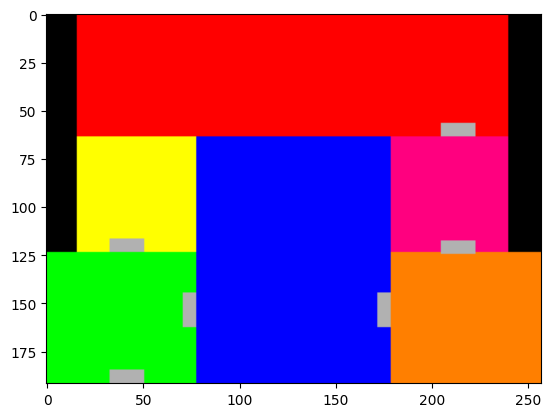

In [44]:
f.image2tensor()
f.view_plan_image()

<module 'matplotlib.pyplot' from '/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

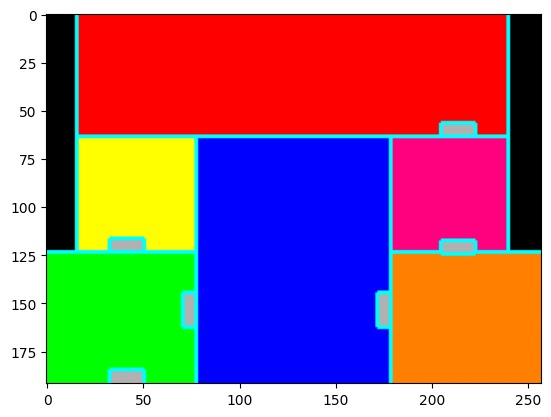

In [45]:
f.segment_tensor()
f.view_plan_segments()

In [46]:
f.tensor_labels

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       ...,
       [6, 6, 6, ..., 5, 5, 5],
       [6, 6, 6, ..., 5, 5, 5],
       [6, 6, 6, ..., 5, 5, 5]], dtype=int8)

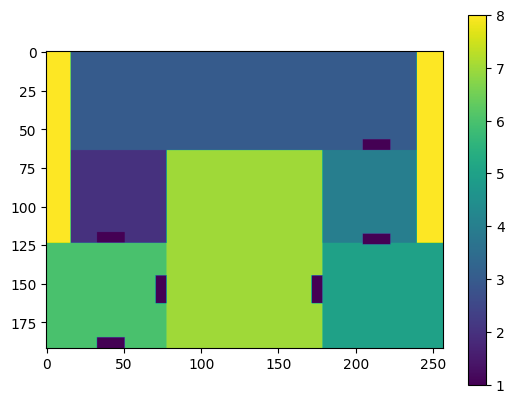

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(f.tensor_labels)
cbar = ax.figure.colorbar(im, )
# plt.bar_label()

In [48]:
f.segment_tensor()
df = f.df
# df["Index"] = df.index

df["X Pos"] = np.indices(f.tensor.shape[0:2])[0].reshape(-1)
df["Y Pos"] = np.indices(f.tensor.shape[0:2])[1].reshape(-1)

df

,R,G,B,Label,X Pos,Y Pos
0,0,0,0,8,0,0
1,0,0,0,8,0,1
2,0,0,0,8,0,2
3,0,0,0,8,0,3
4,0,0,0,8,0,4
...,...,...,...,...,...,...
49339,255,127,0,5,191,252
49340,255,127,0,5,191,253
49341,255,127,0,5,191,254
49342,255,127,0,5,191,255


In [49]:
mask = (df['R'] == 177 ) & (df["G"] == 177) & (df["B"] == 177)

DOOR_LABEL = 100
labels = []
for ix, row in df.iterrows():
    if mask.loc[ix]:
        df.at[ix, "Label"] = DOOR_LABEL

In [50]:
df["Label"].unique()

array([  8,   3, 100,   2,   7,   4,   6,   5], dtype=int8)

In [51]:

tensor_labels

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       ...,
       [6, 6, 6, ..., 5, 5, 5],
       [6, 6, 6, ..., 5, 5, 5],
       [6, 6, 6, ..., 5, 5, 5]])

## splitting doors

/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


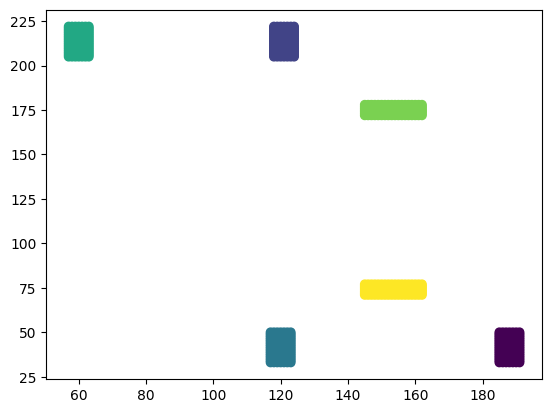

In [53]:
tensor_labels = np.array(df["Label"], dtype=np.int64).reshape(f.tensor_shape[:2])

indices_split = np.where(f.tensor_labels == DOOR_LABEL)
indices = np.argwhere(np.isclose(tensor_labels, DOOR_LABEL))
indices_split = np.where(np.isclose(tensor_labels, DOOR_LABEL))
indices

# TODO make this so dont have to get init clusers
kmeans = KMeans(n_clusters=6)
y_pred = kmeans.fit_predict(indices)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(indices_split[0], indices_split[1], c=y_pred)

In [54]:
new_tensor_labels = f.tensor_labels.copy()

for x, y, door_label in zip(indices_split[0], indices_split[1], y_pred):
    new_tensor_labels[x,y] = 100+door_label # TODO make a higher number, like 100... based on number of expected rooms..

props = meas.regionprops(new_tensor_labels, f.tensor)

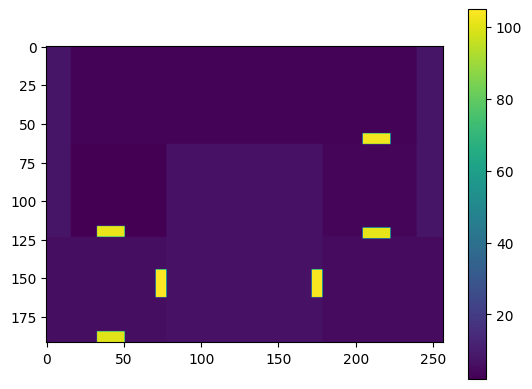

In [55]:
fig, ax = plt.subplots()
im = ax.imshow(new_tensor_labels)
cbar = ax.figure.colorbar(im, )
# harder to see when the door labels are very distinct from the other labels. this is jist a plotting issue that can be fixed with scaling later though 

In [13]:
def rgb_str_to_rgba(rgb_str):
    # Extract numeric values from the string using regular expression
    rgb_values = [int(value) for value in re.findall(r'\d+', rgb_str)]
    
    # Convert to RGBA format
    rgba_values = [value / 255 for value in rgb_values] + [1.0]  # Normalize RGB values to the range [0, 1]
    
    return tuple(rgba_values)



### making regions

In [57]:
class RegionType(Enum):
    ROOM = 0
    DOOR = 1

class newRegion():
    bbox:list = None
    coords:list = None
    shape:Polygon = None
    centroid:tuple = None
    unique_colors:set = None
    type:RegionType = None

0 {(255, 255, 0), (0, 0, 0)} 3720.0 2
1 {(0, 0, 0), (255, 0, 0)} 14336.0 3
2 {(255, 0, 127), (0, 0, 0)} 3660.0 4
3 {(255, 127, 0), (0, 0, 0)} 5304.0 5
4 {(0, 255, 0), (0, 0, 0)} 5304.0 6
5 {(0, 0, 0), (0, 0, 255)} 12928.0 7
6 {(0, 0, 0)} 31868.0 8
7 {(177, 177, 177)} 126.0 100
8 {(177, 177, 177)} 126.0 101
9 {(177, 177, 177)} 126.0 102
10 {(177, 177, 177)} 126.0 103
11 {(177, 177, 177)} 126.0 104
12 {(177, 177, 177)} 126.0 105


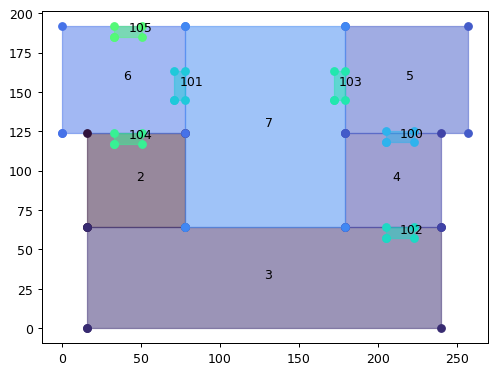

In [15]:
fig = plt.figure(  dpi=90)
ax = fig.add_subplot(111)  

n_colors = 30

colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])
good_colors = [rgb_str_to_rgba(r) for r in colors]

regions = []
for ix, prop in enumerate(props):
    r = newRegion()

    int0 = prop.image_intensity
    s = int0.shape
    int01 = np.reshape(int0, (s[0] * s[1], 3))
    unique_tuples = {tuple(arr) for arr in int01}
    r.unique_colors = unique_tuples
    

    r.coords = create_coords(Bbox(prop.bbox))
    r.shape = Polygon(r.coords)
    r.centroid = (r.shape.centroid.x, r.shape.centroid.y)
    r.label = prop.label
    r.area = prop.bbox_area
    print(ix, unique_tuples, prop.bbox_area, prop.label)

    # TODO code this as doors
    if r.unique_colors == {(177, 177, 177)}:
        r.type = RegionType.DOOR
    else:
        r.type = RegionType.ROOM

    # ignore all regions that are not real rooms 
    if r.unique_colors != {(0,0,0)}:
        regions.append(r)

    

    if ix != 6: 
        splt.plot_polygon(r.shape, ax=ax, alpha=0.5, color=good_colors[ix])
        ax.annotate(str(r.label), r.centroid)
    

In [20]:
# 100 touches 3, 4
# 6=100, 3=5, 2=4

print(regions[6].shape.touches(regions[3].shape))
print(regions[6].shape.touches(regions[2].shape))

False
False


In [21]:

print(regions[6].shape.intersects(regions[3].shape))
print(regions[6].shape.intersects(regions[2].shape))

True
True


In [102]:
print(regions[6].shape.relate(regions[1].shape))
print(regions[6].shape.relate(regions[2].shape))

2FF11F212
FF2F11212


In [100]:
print(regions[11].shape.intersects(regions[1].shape))
print(regions[11].shape.intersects(regions[2].shape))

False
False


In [103]:
print(regions[11].shape.relate(regions[1].shape))
print(regions[11].shape.relate(regions[2].shape))

FF2FF1212
FF2FF1212


In [97]:
# 102 touches 4, 5
print(regions[8].shape.touches(regions[2].shape))
print(regions[8].shape.touches(regions[3].shape))

False
False


In [101]:
print(regions[8].shape.intersects(regions[2].shape))
print(regions[8].shape.intersects(regions[3].shape))

True
True


In [19]:
print_many_attributes_from_instances(regions, ["label"])

0: label: 2
1: label: 3
2: label: 4
3: label: 5
4: label: 6
5: label: 7
6: label: 100
7: label: 101
8: label: 102
9: label: 103
10: label: 104
11: label: 105


In [ ]:
# see if can determine relationship between one shape and all others.. -> used a graph to do this .. but now want a bit different 
# only check adjacency for nodes with the label of door.. 
# but lets first explore relationships... 

In [83]:
print_attribute_from_instances(regions, "unique_colors")

unique_colors for newRegion: {(255, 255, 0), (0, 0, 0)}
unique_colors for newRegion: {(0, 0, 0), (255, 0, 0)}
unique_colors for newRegion: {(255, 0, 127), (0, 0, 0)}
unique_colors for newRegion: {(255, 127, 0), (0, 0, 0)}
unique_colors for newRegion: {(0, 255, 0), (0, 0, 0)}
unique_colors for newRegion: {(0, 0, 0), (0, 0, 255)}
unique_colors for newRegion: {(177, 177, 177)}
unique_colors for newRegion: {(177, 177, 177)}
unique_colors for newRegion: {(177, 177, 177)}
unique_colors for newRegion: {(177, 177, 177)}
unique_colors for newRegion: {(177, 177, 177)}
unique_colors for newRegion: {(177, 177, 177)}


In [81]:
print_keys_values(regions[6])

unique_colors: {(177, 177, 177)}
coords: [(205, 57), (223, 57), (223, 64), (205, 64)]
shape: POLYGON ((205 57, 223 57, 223 64, 205 64, 205 57))
centroid: (214.0, 60.5)
label: 100
area: 126.0


# test 

In [18]:
len(f.regions)

AttributeError: 'FloorPlan2Graph' object has no attribute 'regions'

In [ ]:
# dont want to plot regions with label 8 or 1 with shapely 
all_region_props = meas.regionprops(f.tensor_labels, f.tensor)
all_region_props

In [ ]:
f.regions = f.regions[1:7]

In [ ]:
f.regions

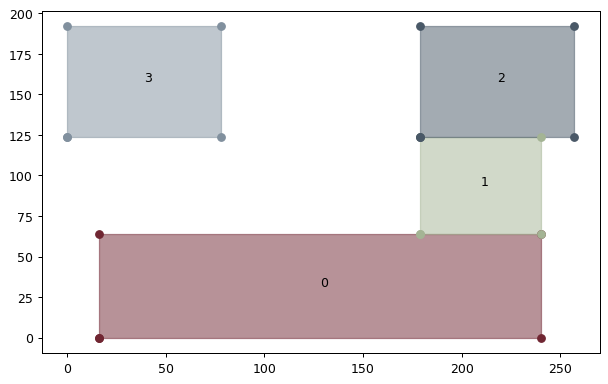

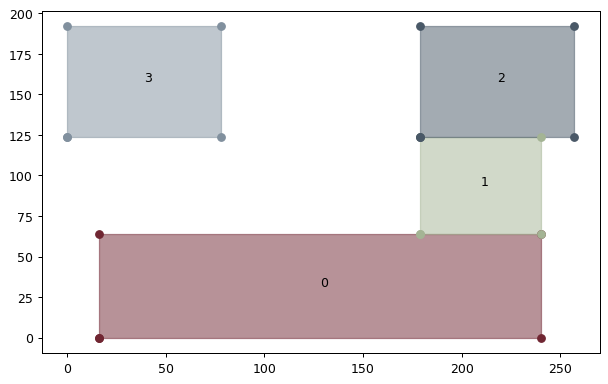

In [ ]:
f.view_plan_shapely()

In [ ]:
# based on image_intensity prop (has to update meas.region_props to recive unlabeled image), can see that 0 and 7 are the regions of interest. with 0 being the doors. although can search after the fact, can also consider dictionary, or including the values in 
all_region_props[7].image_intensity

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
all_region_props[0]?

Type:        RegionProperties
String form: <skimage.measure._regionprops.RegionProperties object at 0x122791a60>
File:        ~/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/skimage/measure/_regionprops.py
Docstring:  
Please refer to `skimage.measure.regionprops` for more information
on the available region properties.


IndexError: list index out of range

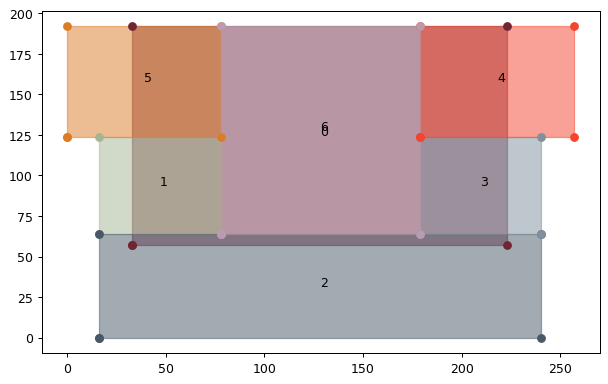

In [ ]:
f.array2shapely()
_ = f.view_plan_shapely()